# Transition 

In this notebook, we compute transitional dynamics after an unexpected (zero probability) aggregate shock (MIT shock). "Zero probability" means that agents' behavior is not affected. For instance, they do not accumulate precautionary savings, because they simply do not expect the shock. 

#### Load packages

In [1]:
using Parameters
using Setfield
using Interpolations
using Plots
using Roots

#### Set up structures

In [2]:
@with_kw struct ModelParameters{T} # Economic Variables
    β :: T = 0.95
    γ :: T = 2.0
    ϵ :: T = 4.06
    χ :: T = 1.0
    α :: T = 0.36
    δ :: T = 0.1
    X :: T = 1.1
    τ :: T = 0.2
    ρ :: T = 0.9136 # Floden and Lindé (2001)
    σ2 :: T = 0.0426 # Floden and Lindé (2001)
end 

@with_kw struct EqParameters{T} # Equilibrium Variables
    r :: T = 0.03   # interest rate
    w :: T = 1.0    # wage
    K :: T = ((r + m_par.δ)/( m_par.X * m_par.α))^(1/(m_par.α-1)) # capital
end 

@with_kw struct NumericalParameters # Numerical Variables
    na   :: Int = 200 # asset grid
    na_c :: Int = 100
    amin :: Float64 = 0.0 
    amax :: Float64 = 50.0 
    ny   :: Int = 5 # income grid
    tol_pol :: Float64 = 1e-7
    max_iter :: Int = 500
end

# Load it already here, as it is needed below
n_par= NumericalParameters()

@with_kw struct ContainerHA{T} # T= Array{Float64,1}
    A  :: T  = zeros(n_par.na, n_par.ny) # policy function assets
    C  :: T  = zeros(n_par.na, n_par.ny) # policy function consumption
    N  :: T  = zeros(n_par.na, n_par.ny) # policy function hours worked
end

@with_kw struct Grids
    gridA :: Array{Float64,1} = zeros(n_par.na)         # asset grid
    Π :: Array{Float64,2} = zeros(n_par.ny, n_par.ny)   # transition matrix income
    gridθ :: Array{Float64,1} = zeros(n_par.ny)         # productivity grid
end

Grids

#### Discretization

In [3]:
function Rouwenhorst_AR1(ρ, σ2, N)

    p= (1+ρ)/2
    q= (1+ρ)/2
    
    # Construct Markov Chain recursively
    if N ==2
        tm= [p 1-p; 1-q q]
    elseif N>2
        tm= [p 1-p; 1-q q]
        for i in 2:N-1
            tm= p .* hcat( vcat(tm, zeros(1,i)), zeros(i+1,1) ) + 
            (1-p) .* hcat( zeros(i+1,1), vcat(tm, zeros(1,i)) ) +
            (1-q) .* hcat( vcat(zeros(1,i), tm), zeros(i+1,1) ) +
                q .* hcat( zeros(i+1,1), vcat(zeros(1,i), tm) )
            
            tm[2:end-1,:]= tm[2:end-1,:]./2 # divide all but the first and last row by two
        end
    else
        println("The number of grid points needs to be larger than two")
    end
    
    # Create state vector - here M is basically sqrt(iN-1)
    ψ= sqrt((σ2 / (1 - ρ^2))) * sqrt(N - 1)
    state= LinRange(-ψ, ψ, N)

    return state, tm

end # end Rouwenhorst_AR1 function

Rouwenhorst_AR1 (generic function with 1 method)

#### EGM (with endogenous labor)

In [4]:
function findMinimumConsumption(c, aprime, a, r, w, θ, γ, ϵ, χ, τ)

    n= max(0.0, 1.0 - ( ( c^(-γ) * (1 - τ) * w * θ) /χ)^(-1/ϵ) ) # intra-temporal FOC

    rt= aprime + c - (1+r)*a - (1-τ)*w*θ*n # budget

    return rt

end


function egm_step(m_par::ModelParameters, n_par::NumericalParameters, grids::Grids, Cprime, Cl, r, rprime, w)

    # Unpack
    @unpack_ModelParameters m_par
    @unpack_NumericalParameters n_par
    @unpack_Grids grids

    # Pre-allocation
    Ci= similar(Cprime, Float64)

    EUc= Cprime.^(-γ) * Π'  # RHS Euler (expectation)
    for y in 1:ny

        # unconstrained
        Cendog= ((1+rprime) .* β .* EUc[:,y]).^(-1/γ) # inter-temporal FOC (Euler)
        Nendog= max.(0.0, 1.0 .- ( ( Cendog.^(-γ) .* (1 - τ) .* w .* gridθ[y]) ./χ).^(-1/ϵ) ) # intra-temporal FOC
        Aendog= (gridA .+ Cendog .- (1 - τ).*w.*Nendog.*gridθ[y]) ./ (1 + r) # budget constraint
        
        # constrained
        if Aendog[1] > amin            
            Cendog_c= collect(LinRange(Cl[y], Cendog[1], na_c)[1:na_c-1]) # get consumption on lower bound
            Nendog_c= max.(0.0, 1.0 .- ( ( Cendog_c.^(-γ) .* (1 - τ) .* w .* gridθ[y]) ./χ).^(-1/ϵ) )
            Aendog_c= (amin .+ Cendog_c .- (1 - τ).*w.*Nendog_c.*gridθ[y]) ./ (1 + r)

            Cendog= append!(Cendog_c, Cendog)
            Aendog= append!(Aendog_c, Aendog)
        end

        itpC= LinearInterpolation(Aendog, Cendog, extrapolation_bc=Line())
        Ci[:,y]= itpC.(gridA)

    end

    return Ci

end

function egm(gV_conHA::ContainerHA, m_par::ModelParameters, n_par::NumericalParameters, grids::Grids, r, rprime, w)

    # Unpack
    @unpack_ContainerHA gV_conHA
    
    
    Ci= copy(C)
    difference= 1000.0
    it=1
    Cl= zeros(n_par.ny)


    # Find consumption at lower bound (constrained agents)
    for y in 1:n_par.ny
        Croot= (c -> findMinimumConsumption(c, n_par.amin, n_par.amin, r, w, grids.gridθ[y], m_par.γ, m_par.ϵ, m_par.χ, m_par.τ)) # recover consumption if at lower bounds - Euler does not hold with equality - only use intra-temporal FOC and budget
        Cl[y]= find_zero(Croot, 1e-6 )
    end
    Cl[Cl.<=1e-6] .= 1e-6 # set min consumption


    while difference > n_par.tol_pol && it < n_par.max_iter
        Ci= egm_step(m_par, n_par, grids, C, Cl, r, rprime, w)
        # Check and update
        difference= maximum(abs.(C .- Ci))
        C= copy(Ci)
        it= it+1
    end # end while


    # Fill policy functions
    for y in 1:n_par.ny
        N[:,y]= max.(0.0, 1.0 .- ( ( C[:,y].^(-m_par.γ) .* (1 - m_par.τ) .* w .* grids.gridθ[y]) ./m_par.χ).^(-1/m_par.ϵ) )
        A[:,y]= (1 - m_par.τ) .* w .* N[:,y] .* grids.gridθ[y] .+ (1+r).*grids.gridA .- C[:,y]
    end

    gV_conHA= ContainerHA(A=A, C=C, N=N) 

    # println("Finished EGM in iteration = ", it, ", and diff = ", difference)

    return gV_conHA

end

egm (generic function with 1 method)

#### (Stationary) Distribution 

In [5]:
function weights_and_indices(A,gridA,na,ny)

    A_indices= zeros(Int, na, ny) 
    wei= zeros(Float64,na,ny) 

    for y in 1:ny
        # Indices
        A_indices[:,y] = searchsortedlast.(Ref(gridA), A[:,y])  # gives left bracket; 0 if below grid, na if above grid
    end
    A_indices[A_indices .== 0] .= 1
    A_indices[A_indices .== na] .= na-1
    for y in 1:ny
        wei[:,y]= (A[:,y] .- [gridA[i] for i in A_indices[:,y]]) ./ ([gridA[i+1] for i in A_indices[:,y]] .- [gridA[i] for i in A_indices[:,y]])
    end
    # should never be binding, but just to be save
    wei[wei.>1] .=1
    wei[wei.<0] .=0

    return wei, A_indices

end


function loop!(A_disti::Array{Float64,2},A_indices::Array{Int,2},wei::Array{Float64,2},Π::Array{Float64,2},A_dist::Array{Float64,2},na::Int,ny::Int)

    @inbounds for i in 1:na
        for s in 1:ny
            index= A_indices[i,s]
            lottery1= (1-wei[i,s]) * A_dist[i,s]
            lottery2= wei[i,s]* A_dist[i,s]
            for si in 1:ny
                A_disti[index,si] += lottery1 * Π[s,si]
                A_disti[index + 1,si] += lottery2 * Π[s,si] 
            end
        end
    end

end

function density_discretization(gV_conHA::ContainerHA, grids::Grids, n_par::NumericalParameters,A_dist)

    # Unpack
    @unpack_NumericalParameters n_par
    @unpack_Grids grids
    
    # retrieve indices and weights for lottery
    wei, A_indices= weights_and_indices(gV_conHA.A, gridA, na, ny)

    difference= 100.0
    it=1
    # iterate over discretized density to get fixed point
    while difference > 1e-10 && it < 10000
    
        # always pre-allocate to zero
        A_disti= zeros(Float64,na,ny) 

        loop!(A_disti, A_indices, wei, Π, A_dist, na, ny)

        difference= maximum(abs.(A_disti .- A_dist))
        A_dist= A_disti ./ sum(A_disti)
        it= it+1

    end

    it == 10000 ? println("density_discretization did not converge") : Nothing

    return A_dist

end

density_discretization (generic function with 1 method)

#### Initialize

In [6]:
m_par= ModelParameters{Float64}()
gV_conHA= ContainerHA{Array{Float64,2}}();
eq_par= EqParameters();

lnproductivtyGrid, transitionMatrix= Rouwenhorst_AR1(m_par.ρ,m_par.σ2,n_par.ny);
productivityGrid= exp.(lnproductivtyGrid)

gridA= n_par.amin .+ (collect(0:n_par.na-1)./n_par.na).^2 .* (n_par.amax - n_par.amin);
grids= Grids(gridA=gridA, Π=transitionMatrix, gridθ=productivityGrid);

#### Steady state

In [7]:
# Guess
Cguess= ones(n_par.na, n_par.ny) .* eq_par.r .+ gridA;
gV_conHA= ContainerHA(C=Cguess);
mA_dist= ones(n_par.na, n_par.ny) ./ (n_par.na * n_par.ny) # start from uniform
Lsupply= 1.0

### Iterate on asset market clearing - one could also use a root-finder to solve for r, but this is for illustration
differenceMarketClearing= 100.0
iterationMarketClearing=1
while differenceMarketClearing > 1e-7 && iterationMarketClearing < 300

    ### FIRM 
    # Update capital
    K = ((m_par.X * m_par.α)/(eq_par.r + m_par.δ))^(1/(1-m_par.α)) * Lsupply
    # Update wage
    w = m_par.X * (1 - m_par.α)*K^m_par.α * Lsupply^(-m_par.α)

    # EGM
    gV_conHA= egm(gV_conHA, m_par, n_par, grids, eq_par.r, eq_par.r, w);

    # Stationary distribution
    mA_dist= density_discretization(gV_conHA, grids, n_par, mA_dist)


    # Aggregates
    dA= sum(mA_dist .* gV_conHA.A)
    Lsupply= sum(mA_dist .* (gV_conHA.N .* grids.gridθ'))

    # Market clearing
    differenceMarketClearing= abs(dA - K)

    # println("Market clearing = ", differenceMarketClearing, " in iteration ", iterationMarketClearing)

    # Update
    rnew= eq_par.r - 0.001*(dA - K) # if demand for assets is bigger than supply, decrease interest rate
    eq_par= @set! eq_par.r = rnew

    iterationMarketClearing= iterationMarketClearing+1

end

# Update final 
eq_par = @set! eq_par.K = ((m_par.α * m_par.X)/(eq_par.r + m_par.δ))^(1/(1-m_par.α)) * Lsupply
eq_par = @set! eq_par.w = m_par.X * (1 - m_par.α)*eq_par.K^m_par.α * Lsupply^(-m_par.α)
println("Equilibrium = ", eq_par)

println("Capital to output ratio: ", eq_par.K / (eq_par.K^m_par.α * Lsupply^(1-m_par.α)))


Equilibrium = EqParameters{Float64}
  r: Float64 0.03231409286270606
  w: Float64 1.3042858055943531
  K: Float64 2.1036759841016552

Capital to output ratio: 2.992878471463385


In [8]:
eq_par= EqParameters();
# Guess
Cguess= ones(n_par.na, n_par.ny) .* eq_par.r .+ gridA;
gV_conHA= ContainerHA(C=Cguess);
mA_dist= ones(n_par.na, n_par.ny) ./ (n_par.na * n_par.ny) # start from uniform

function solve_aiyagari_ss(r, m_par, gV_conHA, mA_dist)

    # Wage implied by interest rate
    w = m_par.X * (1 - m_par.α) * ( (m_par.X * m_par.α) / (r + m_par.δ))^( m_par.α/(1-m_par.α) ) 

    ## Households
    # EGM
    gV_conHA= egm(gV_conHA, m_par, n_par, grids, r, r, w);

    # Stationary distribution
    mA_dist= density_discretization(gV_conHA, grids, n_par, mA_dist)

    # Aggregates
    dA= sum(mA_dist .* gV_conHA.A)
    Lsupply= sum(mA_dist .* (gV_conHA.N .* grids.gridθ'))

    # Update capital
    K = ((m_par.α * m_par.X)/(r + m_par.δ))^(1/(1-m_par.α)) * Lsupply

    return dA - K

end

Helper= (r -> solve_aiyagari_ss(r, m_par, gV_conHA, mA_dist))
r_sol= find_zero(Helper, (0.01,0.04), Bisection(), atol=1e-7)
@set! eq_par.r= r_sol
@set! eq_par.w = m_par.X * (1 - m_par.α) * ( (m_par.α * m_par.X) / (r_sol + m_par.δ))^( m_par.α/(1-m_par.α) ) 

gV_conHA= egm(gV_conHA, m_par, n_par, grids, eq_par.r, eq_par.r, eq_par.w);
mA_dist= density_discretization(gV_conHA, grids, n_par, mA_dist)
Lsupply= sum(mA_dist .* (gV_conHA.N .* grids.gridθ'))

eq_par = @set! eq_par.K = ((m_par.X * m_par.α)/(eq_par.r + m_par.δ))^(1/(1-m_par.α)) * Lsupply
println("Equilibrium = ", eq_par)

println("Capital to output ratio: ", eq_par.K / (eq_par.K^m_par.α * Lsupply^(1-m_par.α)))


Equilibrium = EqParameters{Float64}
  r: Float64 0.032314129136502744
  w: Float64 1.3042856044619175
  K: Float64 2.1036750186754447

Capital to output ratio: 2.9928776509685067


In [9]:
# Walras law - check goods market clearing: Y = C + G + I
Y_ss= m_par.X * eq_par.K^m_par.α * Lsupply^(1-m_par.α)
C_ss= sum(mA_dist .* gV_conHA.C)
I_ss= m_par.δ * eq_par.K
G_ss= m_par.τ * eq_par.w * sum(mA_dist .* (gV_conHA.N .* grids.gridθ'))
print( Y_ss - C_ss - I_ss - G_ss)

-1.1361047103086719e-9

### Transition with respect to TFP shock

In [10]:
function backward_policy(gV_conHA2, m_t, n_par, grids, vr_t, vw_t, iT)

    mAPol_t= zeros(n_par.na, n_par.ny, iT)
    mNPol_t= zeros(n_par.na, n_par.ny, iT)
    mCPol_t= zeros(n_par.na, n_par.ny, iT)
    Cl= zeros(n_par.ny)

    wei_t= zeros(Float64, n_par.na,n_par.ny, iT)
    A_indices_t= zeros(Int, n_par.na, n_par.ny, iT)

    # Fixed objects - will not be updated during transition
    mCPol_t[:,:,end]= copy(gV_conHA2.C) # start from terminal steady state policy (iterate backwards)
    mNPol_t[:,:,end]= copy(gV_conHA2.N)
    mAPol_t[:,:,end]= copy(gV_conHA2.A)

    for t=iT-1:-1:1 #iterate backward

        r= vr_t[t]
        rprime= vr_t[t+1]
        w= vw_t[t]

        # Find consumption at lower bound (constrained agents)
        for y in 1:n_par.ny
            Croot= (c -> findMinimumConsumption(c, n_par.amin, n_par.amin, r, w, grids.gridθ[y],  m_t[t].γ,  m_t[t].ϵ,  m_t[t].χ, m_t[t].τ)) # recover consumption if at lower bounds - Euler does not hold with equality - only use intra-temporal FOC and budget
            Cl[y]= find_zero(Croot, 1e-6 )
        end
        Cl[Cl.<=1e-6] .= 1e-6 # set min consumption
        
        mCPol_t[:,:,t]= egm_step( m_t[t], n_par, grids, mCPol_t[:,:,t+1], Cl, r, rprime, w)

        # Fill policy functions
        for y in 1:n_par.ny
            mNPol_t[:,y,t]= max.(0.0, 1.0 .- ( ( mCPol_t[:,y,t].^(- m_t[t].γ) .* (1 -  m_t[t].τ) .* w .* grids.gridθ[y]) ./ m_t[t].χ).^(-1/ m_t[t].ϵ) )
            mAPol_t[:,y,t]= (1 -  m_t[t].τ) .* w .* mNPol_t[:,y,t] .* grids.gridθ[y] .+ (1+r).*grids.gridA .- mCPol_t[:,y,t]
        end

        # Save weights to iterate distribution
        wei_t[:,:,t], A_indices_t[:,:,t]= weights_and_indices(mAPol_t[:,:,t], gridA, n_par.na, n_par.ny)

    end


    return mCPol_t, mAPol_t, mNPol_t, wei_t, A_indices_t

end


function density_forward(wei_t, A_indices_t, Π, ny, na, mA_dist, t)

    mAdisti= zeros(na,ny)

    loop!(mAdisti,A_indices_t[:,:,t],wei_t[:,:,t],Π,mA_dist,na,ny)

    mA_dist= mAdisti ./ sum(mAdisti)

    return mA_dist

end


function forward_distribution(mA_dist_ss, wei_t, A_indices_t, grids, n_par, iT)

    # Initialize
    mA_dist_t= zeros(Float64, n_par.na,n_par.ny, iT)
    mA_dist_t[:,:,1]= copy(mA_dist_ss) # start from initial distribution (iterate forwards)

    for t in 1:iT-1
        # Iterate distribution forward
        mA_dist_t[:,:,t+1]= density_forward(wei_t, A_indices_t, grids.Π, n_par.ny, n_par.na, mA_dist_t[:,:,t], t)
    end # end forward iteration 

    return mA_dist_t

end

forward_distribution (generic function with 1 method)

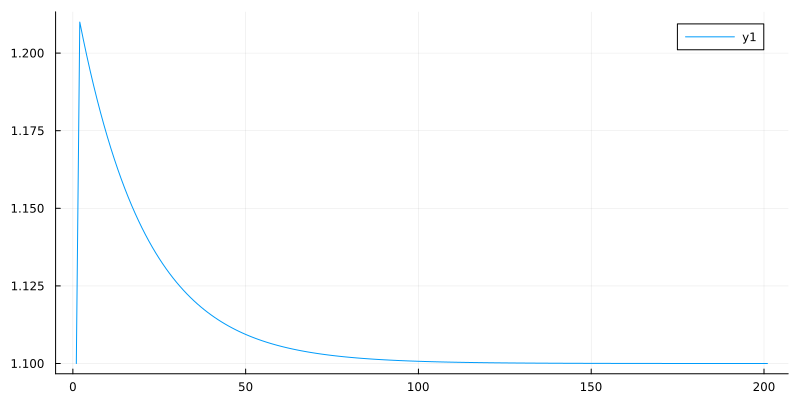

In [12]:
iT= 200 # transition period

dX_ss= m_par.X
dX_shock= 1.1 # value of initial shock 
dX_rho= 0.95 # persistence of shock

vX= ones(iT) * m_par.X
vX[1]= dX_shock*dX_ss

for t in 2:iT
    vX[t]= (1 - dX_rho) * dX_ss + vX[t-1]*dX_rho
end

plot(append!([dX_ss],vX))
plot!(size=(800,400))


In [13]:
function full_transition(gV_conHA1, gV_conHA2, mA_dist1, mA_dist2, eq_par1, eq_par2, m_par1, m_par2, n_par, grids, vX_t, vτ_t, iT)

    # # Updating weights
    # dSpeed   = 3.0
    # dDecay   = 0.01
    # weight  = exp.(-dDecay .* collect(0:iT-1)) #exponentially decaying weights
    # weight  = dSpeed .* weight ./ sum(weight)
    
    
    # Guess
    vK_t= ones(iT) .* eq_par2.K
    vL_t= ones(iT) .* sum(mA_dist2 .* (gV_conHA2.N .* grids.gridθ'))

    # Pack transition
    m_t = Array{typeof(m_par1), 1}(undef, iT)
    fill!(m_t, m_par2) # initialize
    for t in 1:iT
        m_t[t]= setproperties(m_t[t], (τ=vτ_t[t], X=vX_t[t]))
    end

    # Pre-allocation
    vr_t= zeros(iT)
    vw_t= zeros(iT)
    vAssetDemand_t= zeros(iT)
    vAssetDemand_t[1]= eq_par1.K # initial capital is pre-determined
    vAssetDemand_t2= zeros(iT)
    vAssetDemand_t2[1]= eq_par1.K 


    
    # pre-allocate s.t. they can be returned
    mAPol_t= zeros(n_par.na, n_par.ny, iT)
    mNPol_t= zeros(n_par.na, n_par.ny, iT)
    mCPol_t= zeros(n_par.na, n_par.ny, iT)
    mA_dist_t= zeros(n_par.na, n_par.ny, iT)

    iteration_transition=1 
    res= 1.0

    for iter in 1:100
    # for iter in 1:5

        for t in 1:iT
            vr_t[t] = m_t[t].X *  m_t[t].α * vK_t[t]^(m_t[t].α -1.0) * vL_t[t]^(1-m_t[t].α) - m_t[t].δ
            vw_t[t] = m_t[t].X * (1 - m_t[t].α) * vK_t[t]^m_t[t].α * vL_t[t]^(-m_t[t].α)
        end

        mCPol_t, mAPol_t, mNPol_t, wei_t, A_indices_t= backward_policy(gV_conHA2, m_t, n_par, grids, vr_t, vw_t, iT);
        
        mA_dist_t= forward_distribution(mA_dist1, wei_t, A_indices_t, grids, n_par, iT); 
    

        # Aggregates
        for t in 1:iT-1
            ## Calculate asset holdings
            vAssetDemand_t[t+1]= sum(mA_dist_t[:,:,t] .* mAPol_t[:,:,t]) # A_{t+1} = ∫ a_{t+1}(a,θ) dλ_t
            vL_t[t]= sum(mA_dist_t[:,:,t] .* (mNPol_t[:,:,t] .* grids.gridθ'))
        end
        for t in 1:iT-1
            vAssetDemand_t2[t+1]= sum( sum(mA_dist_t[:,:,t+1], dims=2) .* grids.gridA) # A_{t+1} = ∫ a dλ_{t+1}
        end


        # Check
        assetMarketClearing_transition= vK_t .- vAssetDemand_t
        res= maximum(abs.(assetMarketClearing_transition)) # max norm

        if mod(iteration_transition, 10) == 0
            println("Market clearing over transition: ", res, " in iteration ", iteration_transition)
        end

        if res < 1e-4
            break
        end
    
        # Naive updating
        vK_t= vK_t .- 0.1 .* assetMarketClearing_transition 

        iteration_transition= iteration_transition+1

    end
    
    println("Finished in iteration ", iteration_transition, " with market clearing ", res, " and end-difference ", vK_t[end] - eq_par2.K)
    
    return vr_t, vw_t, vK_t, mCPol_t, mAPol_t, mNPol_t, mA_dist_t, vAssetDemand_t, vAssetDemand_t2
    
    end

full_transition (generic function with 1 method)

In [14]:
vr_t, vw_t, vK_t, mCPol_t, mAPol_t, mNPol_t, mA_dist_t, vAssetDemand_t, vAssetDemand_t2= full_transition(gV_conHA, gV_conHA, mA_dist, mA_dist, eq_par, eq_par, m_par, m_par, n_par, grids, vX, ones(200).* m_par.τ, 200);

Market clearing over transition: 0.045962709158562376 in iteration 10
Market clearing over transition: 0.00796800978405443 in iteration 20
Market clearing over transition: 0.001797666402575615 in iteration 30
Market clearing over transition: 0.0004552340166994462 in iteration 40
Market clearing over transition: 0.00012382759107554264 in iteration 50
Finished in iteration 52 with market clearing 9.582663471041641e-5 and end-difference 4.165350440565874e-5


In [15]:
println(maximum(abs.(vAssetDemand_t .- vAssetDemand_t2)))

7.055689366097795e-12


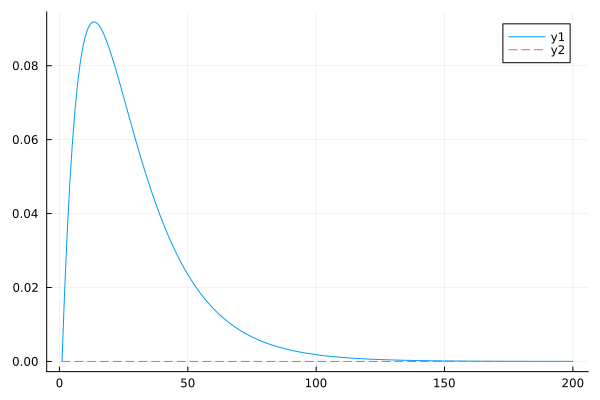

In [16]:
plot(vK_t ./ eq_par.K .- 1)
plot!(zeros(iT), ls=:dash)

In [17]:
### Transition to a different steady state - TFP
# SS1
Helper= (r -> solve_aiyagari_ss(r, m_par, gV_conHA, mA_dist))
r_sol= find_zero(Helper, (0.01,0.04), Bisection(), atol=1e-7)
eq_par1= setproperties(eq_par, (r=r_sol))
@set! eq_par1.w = m_par.X * (1 - m_par.α) * ( (m_par.α * m_par.X ) / (r_sol + m_par.δ))^( m_par.α/(1-m_par.α) ) 

gV_conHA1= egm(gV_conHA, m_par, n_par, grids, eq_par1.r, eq_par1.r, eq_par1.w);
mA_dist1= density_discretization(gV_conHA1, grids, n_par, mA_dist)
Lsupply1= sum(mA_dist1 .* (gV_conHA1.N .* grids.gridθ'))

eq_par1 = @set! eq_par1.K = ((m_par.X * m_par.α)/(eq_par1.r + m_par.δ))^(1/(1-m_par.α)) * Lsupply1
println("Equilibrium = ", eq_par1)

# SS2
m_par2= setproperties(m_par, (X=2.0))
Helper= (r -> solve_aiyagari_ss(r, m_par2, gV_conHA, mA_dist))
r_sol= find_zero(Helper, (0.01,0.04), Bisection(), atol=1e-7)
eq_par2= setproperties(eq_par, (r=r_sol))
@set! eq_par2.w = m_par2.X * (1 - m_par2.α) * ((m_par2.α * m_par2.X) / (r_sol + m_par2.δ))^( m_par2.α/(1-m_par2.α) ) 

gV_conHA2= egm(gV_conHA, m_par2, n_par, grids, eq_par2.r, eq_par2.r, eq_par2.w);
mA_dist2= density_discretization(gV_conHA2, grids, n_par, mA_dist)
Lsupply2= sum(mA_dist2 .* (gV_conHA2.N .* grids.gridθ'))

eq_par2 = @set! eq_par2.K = ((m_par2.X * m_par2.α)/(eq_par2.r + m_par2.δ))^(1/(1-m_par2.α)) * Lsupply2
println("Equilibrium = ", eq_par2)

Equilibrium = EqParameters{Float64}
  r: Float64 0.03231413006782532
  w: Float64 1.3042855992978832
  K: Float64 2.103674997140311

Equilibrium = EqParameters{Float64}
  r: Float64 0.031964071057736874
  w: Float64 3.3243226210504675
  K: Float64 4.180515779311744



In [18]:
# Smooth it in
vX = 2.0 * ones(200)
steps= 10
# Linearly increase values from dX_ss to 2 in 10 steps
for i in 1:steps
    vX[i] = m_par.X + i * (2.0 - m_par.X) / steps
end
println(vX[1:12])

vr_t, vw_t, vK_t, mCPol_t, mAPol_t, mNPol_t, mA_dist_t, vAssetDemand_t, vAssetDemand_t2= full_transition(gV_conHA1, gV_conHA2, mA_dist1, mA_dist2, eq_par1, eq_par2, m_par, m_par2, n_par, grids, vX, ones(200) .* m_par.τ, 200);

[1.1900000000000002, 1.28, 1.37, 1.46, 1.55, 1.6400000000000001, 1.73, 1.82, 1.9100000000000001, 2.0, 2.0, 2.0]
Market clearing over transition: 0.8531762445510229 in iteration 10
Market clearing over transition: 0.2805503937929599 in iteration 20
Market clearing over transition: 0.09782187367716988 in iteration 30
Market clearing over transition: 0.03410837832141489 in iteration 40
Market clearing over transition: 0.011892856147451614 in iteration 50
Market clearing over transition: 0.004146782529827142 in iteration 60
Market clearing over transition: 0.0014458936639338837 in iteration 70
Market clearing over transition: 0.0005041519472910316 in iteration 80
Market clearing over transition: 0.00017578691455488737 in iteration 90
Finished in iteration 96 with market clearing 9.34203736582262e-5 and end-difference -8.241351423521337e-8


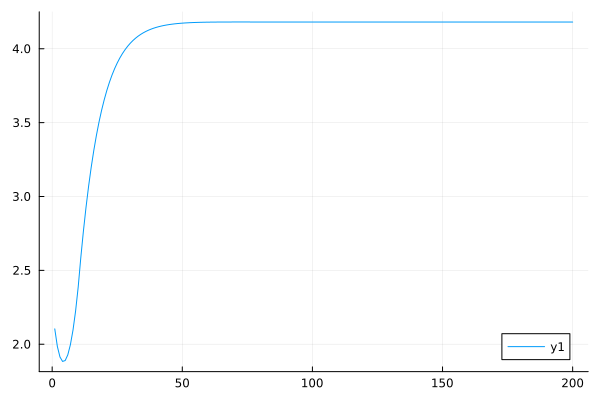

In [19]:
plot(vK_t)

In [20]:
### Transition to a different steady state - Taxes
# SS1
Helper= (r -> solve_aiyagari_ss(r, m_par, gV_conHA, mA_dist))
r_sol= find_zero(Helper, (0.01,0.04), Bisection(), atol=1e-7)
eq_par1= setproperties(eq_par, (r=r_sol))
@set! eq_par1.w = m_par.X * (1 - m_par.α) * ((m_par.X * m_par2.α) / (r_sol + m_par.δ))^( m_par.α/(1-m_par.α) ) 

gV_conHA1= egm(gV_conHA, m_par, n_par, grids, eq_par1.r, eq_par1.r, eq_par1.w);
mA_dist1= density_discretization(gV_conHA1, grids, n_par, mA_dist)
Lsupply1= sum(mA_dist1 .* (gV_conHA1.N .* grids.gridθ'))

eq_par1 = @set! eq_par1.K = ((m_par.X * m_par.α)/(eq_par1.r + m_par.δ))^(1/(1-m_par.α)) * Lsupply1
println("Equilibrium = ", eq_par1)

# SS2
m_par2= setproperties(m_par, (τ=0.3))
Helper= (r -> solve_aiyagari_ss(r, m_par2, gV_conHA, mA_dist))
r_sol= find_zero(Helper, (0.01,0.04), Bisection(), atol=1e-7)
eq_par2= setproperties(eq_par, (r=r_sol))
@set! eq_par2.w = m_par2.X * (1 - m_par2.α) * ((m_par2.X * m_par2.α) / (r_sol + m_par2.δ))^( m_par2.α/(1-m_par2.α) ) 

gV_conHA2= egm(gV_conHA, m_par2, n_par, grids, eq_par2.r, eq_par2.r, eq_par2.w);
mA_dist2= density_discretization(gV_conHA2, grids, n_par, mA_dist)
Lsupply2= sum(mA_dist2 .* (gV_conHA2.N .* grids.gridθ'))

eq_par2 = @set! eq_par2.K = ((m_par2.X * m_par2.α)/(eq_par2.r + m_par2.δ))^(1/(1-m_par2.α)) * Lsupply2
println("Equilibrium = ", eq_par2)

Equilibrium = EqParameters{Float64}
  r: Float64 0.03231413006782532
  w: Float64 1.3042855992978832
  K: Float64 2.103674997140311

Equilibrium = EqParameters{Float64}
  r: Float64 0.03407907109707594
  w: Float64 1.2946001200277035
  K: Float64 2.107017538499558



In [21]:
# Agents wake up and the new tax is implemented
vr_t, vw_t, vK_t, mCPol_t, mAPol_t, mNPol_t, mA_dist_t= full_transition(gV_conHA1, gV_conHA2, mA_dist1, mA_dist2, eq_par1, eq_par2, m_par, m_par2, n_par, grids, ones(200) * m_par.X, ones(200) .* m_par2.τ, 200);

Market clearing over transition: 0.0012949690079024911 in iteration 10
Market clearing over transition: 0.0004515277736532042 in iteration 20
Market clearing over transition: 0.0001574379997788533 in iteration 30
Finished in iteration 35 with market clearing 9.296556448923354e-5 and end-difference -2.030821066867361e-8


In [22]:
# Walras law - check goods market clearing: Y = C + G + I
vY_t= zeros(iT)
vL_t= zeros(iT)
vC_t= zeros(iT)
vG_t= zeros(iT)
vI_t= zeros(iT)
for t in 1:200
    vL_t[t]= sum(mA_dist_t[:,:,t] .* (mNPol_t[:,:,t] .* grids.gridθ'))
    vY_t[t]= m_par.X * vK_t[t]^m_par.α * vL_t[t]^(1-m_par.α)
    vC_t[t]= sum(mA_dist_t[:,:,t] .* mCPol_t[:,:,t])
    vG_t[t]= m_par2.τ * vw_t[t] * sum(mA_dist_t[:,:,t] .* (mNPol_t[:,:,t] .* grids.gridθ'))
end
for t in 1:199
    vI_t[t]= vK_t[t+1] - (1 - m_par.δ) * vK_t[t]
end
vI_t[end]= eq_par2.K - (1 - m_par.δ) * vK_t[end]


print(vY_t - vC_t - vI_t - vG_t)

[3.279909164852213e-5, 2.5391982989758644e-5, 1.9274936998298076e-5, 1.4258044774312362e-5, 1.0191049437835442e-5, 6.934181532108896e-6, 4.362817038860989e-6, 2.3642559404402075e-6, 8.40507250798872e-7, -2.9314614746756007e-7, -1.1088838358930264e-6, -1.6677094477890453e-6, -2.0209886829880563e-6, -2.21182855586477e-6, -2.276398146872083e-6, -2.244957737956854e-6, -2.142565827756293e-6, -1.9898451622812896e-6, -1.8036067083171403e-6, -1.597393079061371e-6, -1.3819617307730958e-6, -1.1657140326915005e-6, -9.55070268232605e-7, -7.547901940685442e-7, -5.682555737074324e-7, -3.977228991147719e-7, -2.4453285241143874e-7, -1.0928817381627987e-7, 7.993435219288969e-9, 1.0774943784430668e-7, 1.9076175350463132e-7, 2.580623387760106e-7, 3.108533500051358e-7, 3.504409304966316e-7, 3.7818128925670713e-7, 3.954376418535688e-7, 4.035467826568606e-7, 4.037936272016651e-7, 3.9739312926445614e-7, 3.854777202438875e-7, 3.690895202801414e-7, 3.491762953500288e-7, 3.265903495419664e-7, 3.020897305083814e

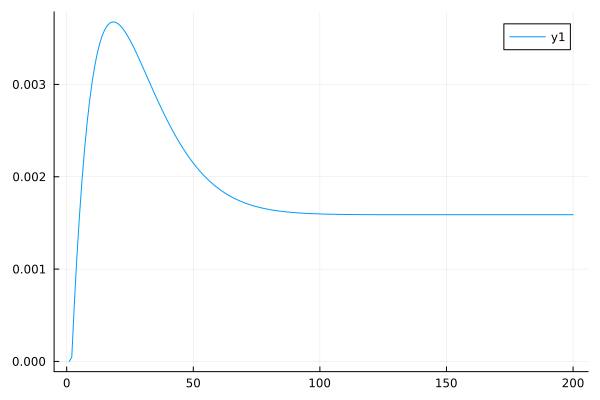

In [23]:
plot([0.0; vK_t./eq_par1.K .- 1][1:200])
# plot([0.0; vw_t./eq_par1.w .- 1])
# plot([eq_par1.r; vr_t])
# plot([0.0; vL_t ./ Lsupply1 .- 1])
